In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimbbaro","key":"0eee4ddbd0a80636c2a3f8146af07993"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 98% 75.0M/76.5M [00:04<00:00, 27.7MB/s]
100% 76.5M/76.5M [00:04<00:00, 18.8MB/s]


In [4]:
!unzip /content/porto-seguro-safe-driver-prediction.zip

Archive:  /content/porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = 'colab'

In [6]:
train = pd.read_csv("/content/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [7]:
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))


The train dataset contains 595212 rows and 59 columns


In [8]:
train.isnull().any().any()

False

In [9]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)


<Axes: >

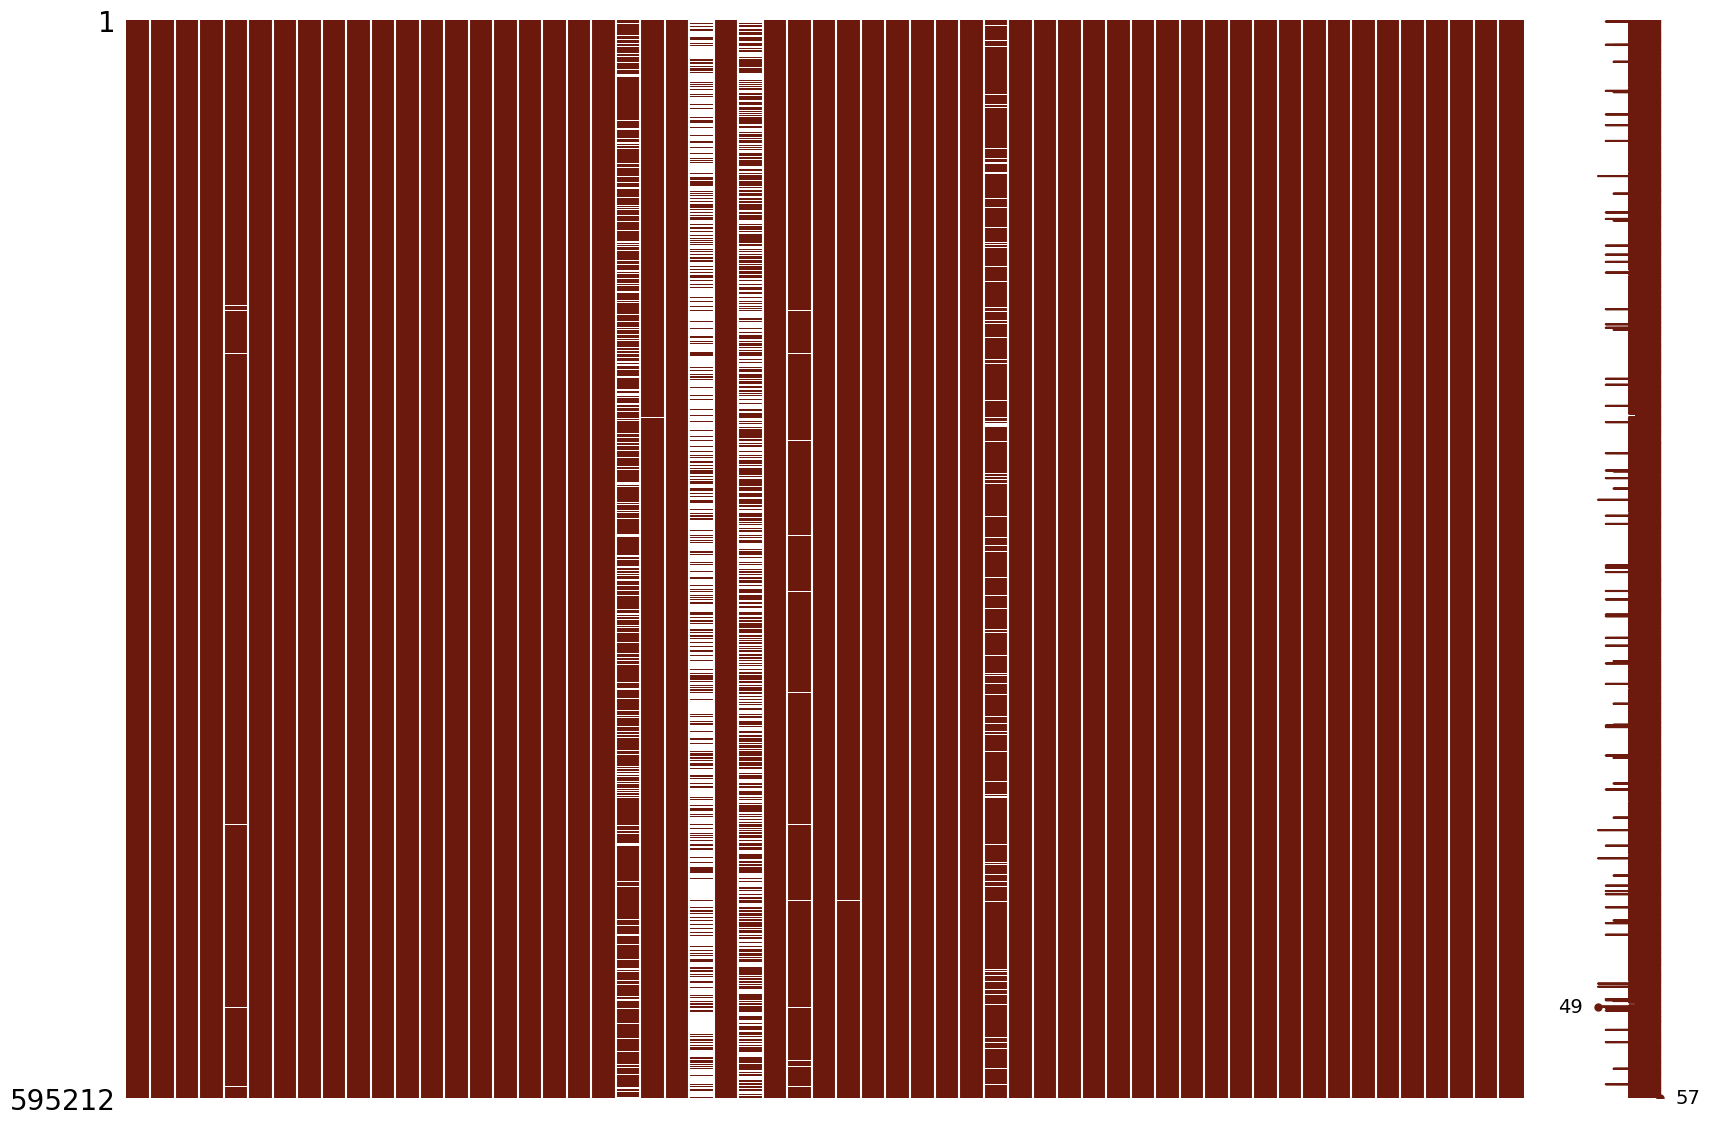

In [17]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:59], figsize = (20,14), color = (0.42, 0.1, 0.05))

In [22]:
data = [go.Bar(
    x = train["target"].value_counts().index.values,
    y = train["target"].value_counts().values,
    text = "Distribution of target variable"
)]

layout = go.Layout(
    title = "Target variable distribution"
)

fig = go.Figure(data=data, layout = layout)
py.iplot(fig, filename = "basic-bar")

In [23]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [24]:
train_float = train.select_dtypes(include = ["float64"])
train_int = train.select_dtypes(include=["int64"])

<Axes: title={'center': 'Pearson correlation'}>

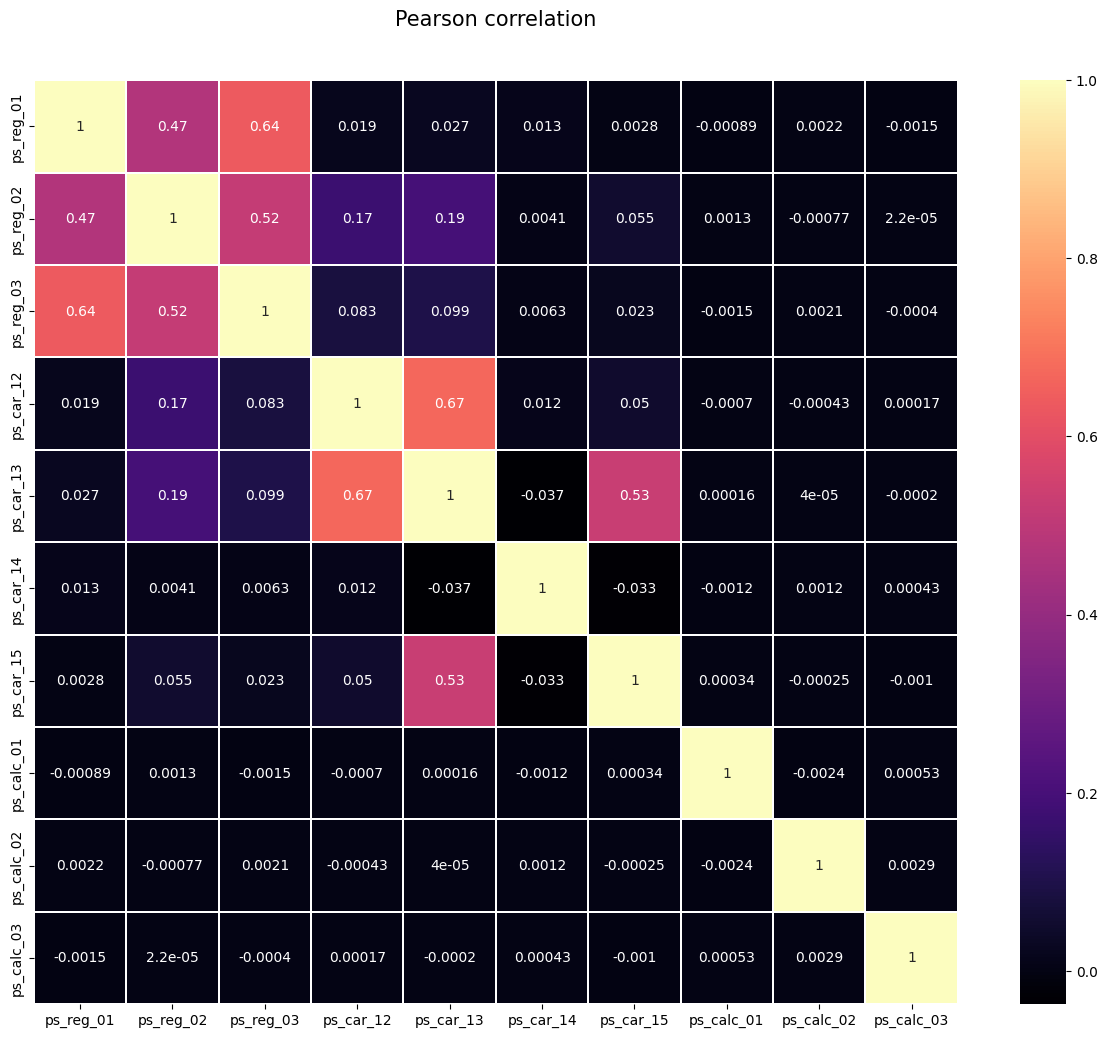

In [25]:
colormap = plt.cm.magma
plt.figure(figsize = (16,12))
plt.title("Pearson correlation", y = 1.05, size = 15)
sns.heatmap(train_float.corr(), linewidths = 0.1, vmax = 1.0, square = True,
            cmap = colormap, linecolor="white", annot = True)

In [28]:
data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = "Virdis",
        reverescale = False,
        text = True,
        opacity = 1.0
    )
]

layout = go.Layout(
    title = "Pearson Correlation",
    xaxis = dict(ticks='', nticks = 36),
    yaxis = dict(ticks=""),
    width = 900, height = 700
)

fig = go.Figure(data = data, layout = layout)
go.iplot(fig, filename = "labelled-heatmap")

ValueError: ignored

In [31]:

import plotly.graph_objs as go

data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = "Viridis",
        reversescale = False,
        text = True,
        opacity = 1.0
    )
]

layout = go.Layout(
    title = "Pearson Correlation of Integer-type Features",
    xaxis = dict(ticks = "", nticks = 36),
    yaxis = dict(ticks = ""),
    width = 900, height = 700
)

fig = go.Figure(data=data, layout=layout)
fig.show()







ValueError: ignored


상호 정보량(Mutual information)은 목표 변수와 해당 특성 간의 상호 정보량을 검사하는 데 유용한 도구입니다
k-nn 사용



In [32]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors = 3, random_state = 17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


In [33]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
  zero_list.append((train[col]==0).sum())
  one_list.append((train[col]==1).sum())

barmode는 그래프의 막대를 어떻게 표시할지 설정하는 매개변수로, "stack"으로 설정

In [34]:
trace1 = go.Bar(
    x = bin_col,
    y = zero_list,
    name = "Zero count"
)

trace2 = go.Bar(
    x= bin_col,
    y= one_list,
    name = "One count"
)

data = [trace1, trace2]
layout = go.Layout(
    barmode = "stack",
    title = "Count of 1 and 0 in binary variables"
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = "stacked-bar")

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(n_estimators = 150, max_depth = 8, min_samples_leaf = 4,
                           max_features = 0.2, n_jobs = -1,
                           random_state = 0)
rf.fit(train.drop(["id", "target"], axis = 1), train.target)
features = train.drop(["id", 'target'],axis = 1).columns.values
print("Training Done")

Training Done


In [36]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x= features,
    mode = 'markers',
    marker = dict(
        sizemode = "diameter",
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = "Portland",
        showscale = True
    ),
    text = features
)

data = [trace]

layout = go.Layout(
    autosize = True,
    title = "Random Forest Feature Importance",
    hovermode = "closest",
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = "Feature Importance",
        showgrid = False, 
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data = data , layout = layout)
py.iplot(fig, filename = "scatter2010")

이 코드는 먼저 zip() 함수를 사용하여 rf.feature_importances_와 features 리스트를 쌍으로 묶습니다. 그런 다음, 이렇게 쌍으로 묶인 리스트를 sorted() 함수를 사용하여 rf.feature_importances_ 값을 기준으로 오름차순으로 정렬합니다. 그리고 이를 다시 zip() 함수를 사용하여 분리된 두 개의 리스트로 되돌립니다. 이 결과 x에는 feature importances 값이, y에는 features 이름이 정렬된 상태로 저장됩니다. 이렇게 함으로써, 뒤에 생성되는 plot에서는 feature importances 값이 낮은 순서대로 x축에 배치됩니다.

In [37]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

tree 모듈에서는 decision tree 알고리즘을 제공합니다.
IPython.display 모듈의 Image 클래스는 Jupyter notebook에서 이미지를 표시하기 위해 사용됩니다.
subprocess 모듈의 check_call 함수는 명령 프롬프트에서 시스템 명령을 실행하는 데 사용됩니다.
PIL(Python Imaging Library) 모듈의 Image, ImageDraw, ImageFont 클래스는 이미지 파일을 생성하고, 이미지에 텍스트를 추가하고, 이미지의 폰트를 조작하는 데 사용됩니다.

In [39]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(["id", "target"], axis = 1), train.target)

with open("tree1.dot", 'w') as f:
  f = tree.export_graphviz(decision_tree,
                           out_file = f,
                           max_depth = 4,
                           impurity = False,
                           feature_names = train.drop(["id", "target"], axis = 1).columns.values,
                           class_names = ["No", "Yes"],
                           rounded = True,
                           filled = True)
  
check_call(["dot", "-Tpng", "tree1.dot", "-o", 'tree1.png'])

img = Image.open("tree.png")
draw = ImageDraw.Draw(img)
img.save("sample-out.png")
PImage("sample-out.png")

FileNotFoundError: ignored

이 코드는 Scikit-learn의 GradientBoostingClassifier를 사용하여, 약한 예측 모델들의 가중평균을 통해 더 강력한 앙상블 모델을 구축합니다. n_estimators는 모델에 사용되는 의사결정나무의 수를, max_depth는 의사결정나무의 최대 깊이를, min_samples_leaf는 각 단말 노드에서 필요한 최소 샘플 수를, max_features는 각 의사결정나무에서 사용될 최대 feature 수를 설정합니다. random_state는 모델의 재현성을 보장하기 위한 랜덤 시드 값입니다. 이 모델은 지도학습 분류 문제를 해결하기 위해 사용될 수 있습니다.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, min_samples_leaf = 4,
                                max_features = 0.2, random_state=0)
gb.fit(train.drop(["id", "target"], axis = 1), train.target)
features = train.drop(["id", "target"], axis = 1).columns.values
print("------------Training Done-----------")

------------Training Done-----------


In [42]:
trace = go.Scatter(
    y = gb.feature_importances_,
    x= features,
    mode = 'markers',
    marker = dict(
        sizemode = "diameter",
        sizeref = 1,
        size =13,
        color = gb.feature_importances_,
        colorscale = "Portland",
        showscale = True
    ),
    text = features
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title ="Gradient Boosting Machine feature importance",
    hovermode = "closest",
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False, 
        showline = False
    ),
    yaxis = dict(
        title = "Feature Importance",
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)
fig = go.Figure(data = data , layout = layout)
py.iplot(fig, filename="scatter2010")

In [43]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')